In [1]:
#Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_14108\2261466704.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_14108\2261466704.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_14108\2261466704.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_14108\2261466704.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is depr

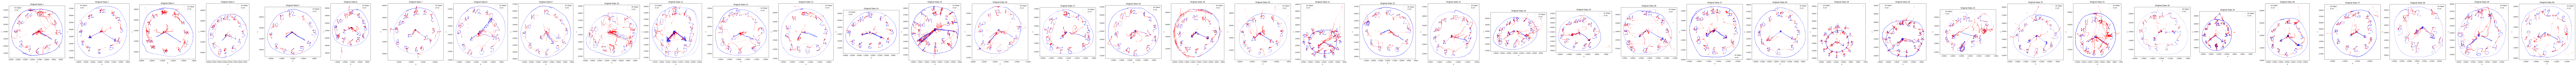

Processed data shape: (160231, 3)
Average number of data points: 4005


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points


directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=40)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")

In [3]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = decoded[:, :2]
        pen_status = tf.round(decoded[:, 2])
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Function to compute loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x[:, :2], x_reconstructed[:, :2]))
    pen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 2], x_reconstructed[:, 2]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + pen_loss, kl_loss, model.beta * kl_loss

latent_dim = 256
beta = 0.0001
# beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100: 100%|██████████| 626/626 [00:17<00:00, 34.79batch/s, Total Loss=6.9, Reconstruction Loss=6.9, KL Loss=1.97]      


Epoch 1: Total Loss = 8.516661, Reconstruction Loss = 8.516545, KL Divergence Loss = 1.183219
MAE = 0.317245, MSE = 0.147363, NRMSE = 0.383879


Epoch 2/100: 100%|██████████| 626/626 [00:11<00:00, 56.29batch/s, Total Loss=7.45, Reconstruction Loss=7.45, KL Loss=1.84]


Epoch 2: Total Loss = 8.507381, Reconstruction Loss = 8.507199, KL Divergence Loss = 1.836822
MAE = 0.307580, MSE = 0.139571, NRMSE = 0.373591


Epoch 3/100: 100%|██████████| 626/626 [00:08<00:00, 71.37batch/s, Total Loss=7.8, Reconstruction Loss=7.8, KL Loss=1.57]  


Epoch 3: Total Loss = 8.507376, Reconstruction Loss = 8.507215, KL Divergence Loss = 1.680232
MAE = 0.299780, MSE = 0.133291, NRMSE = 0.365091


Epoch 4/100: 100%|██████████| 626/626 [00:08<00:00, 75.30batch/s, Total Loss=8.21, Reconstruction Loss=8.21, KL Loss=1.44]


Epoch 4: Total Loss = 8.507411, Reconstruction Loss = 8.507269, KL Divergence Loss = 1.515233
MAE = 0.293058, MSE = 0.128065, NRMSE = 0.357861


Epoch 5/100: 100%|██████████| 626/626 [00:08<00:00, 77.15batch/s, Total Loss=7.94, Reconstruction Loss=7.94, KL Loss=1.29]


Epoch 5: Total Loss = 8.507359, Reconstruction Loss = 8.507219, KL Divergence Loss = 1.361302
MAE = 0.284983, MSE = 0.121727, NRMSE = 0.348894


Epoch 6/100: 100%|██████████| 626/626 [00:08<00:00, 76.98batch/s, Total Loss=8.21, Reconstruction Loss=8.21, KL Loss=1.17]


Epoch 6: Total Loss = 8.507370, Reconstruction Loss = 8.507254, KL Divergence Loss = 1.220861
MAE = 0.277686, MSE = 0.116211, NRMSE = 0.340898


Epoch 7/100: 100%|██████████| 626/626 [00:08<00:00, 69.72batch/s, Total Loss=8.63, Reconstruction Loss=8.63, KL Loss=1.02] 


Epoch 7: Total Loss = 8.507429, Reconstruction Loss = 8.507316, KL Divergence Loss = 1.091986
MAE = 0.270688, MSE = 0.110917, NRMSE = 0.333043


Epoch 8/100: 100%|██████████| 626/626 [00:08<00:00, 77.51batch/s, Total Loss=7.66, Reconstruction Loss=7.66, KL Loss=0.924]


Epoch 8: Total Loss = 8.507249, Reconstruction Loss = 8.507151, KL Divergence Loss = 0.971624
MAE = 0.266225, MSE = 0.107537, NRMSE = 0.327929


Epoch 9/100: 100%|██████████| 626/626 [00:08<00:00, 78.04batch/s, Total Loss=8.42, Reconstruction Loss=8.42, KL Loss=0.842]


Epoch 9: Total Loss = 8.507358, Reconstruction Loss = 8.507272, KL Divergence Loss = 0.874728
MAE = 0.259242, MSE = 0.102304, NRMSE = 0.319850


Epoch 10/100: 100%|██████████| 626/626 [00:07<00:00, 78.72batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.762]


Epoch 10: Total Loss = 8.507283, Reconstruction Loss = 8.507203, KL Divergence Loss = 0.795120
MAE = 0.256377, MSE = 0.100291, NRMSE = 0.316687


Epoch 11/100: 100%|██████████| 626/626 [00:07<00:00, 78.81batch/s, Total Loss=7.87, Reconstruction Loss=7.87, KL Loss=0.711]


Epoch 11: Total Loss = 8.507256, Reconstruction Loss = 8.507181, KL Divergence Loss = 0.742289
MAE = 0.250801, MSE = 0.096140, NRMSE = 0.310064


Epoch 12/100: 100%|██████████| 626/626 [00:07<00:00, 78.46batch/s, Total Loss=8.7, Reconstruction Loss=8.7, KL Loss=0.674]  


Epoch 12: Total Loss = 8.507362, Reconstruction Loss = 8.507288, KL Divergence Loss = 0.693273
MAE = 0.248142, MSE = 0.094101, NRMSE = 0.306758


Epoch 13/100: 100%|██████████| 626/626 [00:08<00:00, 77.76batch/s, Total Loss=8.01, Reconstruction Loss=8.01, KL Loss=0.634]


Epoch 13: Total Loss = 8.507248, Reconstruction Loss = 8.507181, KL Divergence Loss = 0.653183
MAE = 0.245022, MSE = 0.091721, NRMSE = 0.302854


Epoch 14/100: 100%|██████████| 626/626 [00:08<00:00, 76.10batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.585]  


Epoch 14: Total Loss = 8.507394, Reconstruction Loss = 8.507330, KL Divergence Loss = 0.615209
MAE = 0.240838, MSE = 0.088640, NRMSE = 0.297725


Epoch 15/100: 100%|██████████| 626/626 [00:07<00:00, 82.81batch/s, Total Loss=8.07, Reconstruction Loss=8.07, KL Loss=0.563]


Epoch 15: Total Loss = 8.507242, Reconstruction Loss = 8.507188, KL Divergence Loss = 0.575678
MAE = 0.238064, MSE = 0.086432, NRMSE = 0.293993


Epoch 16/100: 100%|██████████| 626/626 [00:08<00:00, 77.38batch/s, Total Loss=7.8, Reconstruction Loss=7.8, KL Loss=0.524]  


Epoch 16: Total Loss = 8.507197, Reconstruction Loss = 8.507149, KL Divergence Loss = 0.542295
MAE = 0.236775, MSE = 0.085495, NRMSE = 0.292396


Epoch 17/100: 100%|██████████| 626/626 [00:08<00:00, 77.55batch/s, Total Loss=7.94, Reconstruction Loss=7.94, KL Loss=0.501]


Epoch 17: Total Loss = 8.507217, Reconstruction Loss = 8.507173, KL Divergence Loss = 0.514911
MAE = 0.233793, MSE = 0.083322, NRMSE = 0.288656


Epoch 18/100: 100%|██████████| 626/626 [00:08<00:00, 76.23batch/s, Total Loss=7.45, Reconstruction Loss=7.45, KL Loss=0.479]


Epoch 18: Total Loss = 8.507137, Reconstruction Loss = 8.507089, KL Divergence Loss = 0.485839
MAE = 0.232136, MSE = 0.082146, NRMSE = 0.286611


Epoch 19/100: 100%|██████████| 626/626 [00:08<00:00, 75.03batch/s, Total Loss=8.01, Reconstruction Loss=8.01, KL Loss=0.456]


Epoch 19: Total Loss = 8.507220, Reconstruction Loss = 8.507175, KL Divergence Loss = 0.465598
MAE = 0.230725, MSE = 0.081191, NRMSE = 0.284941


Epoch 20/100: 100%|██████████| 626/626 [00:08<00:00, 78.24batch/s, Total Loss=9.18, Reconstruction Loss=9.18, KL Loss=0.436]


Epoch 20: Total Loss = 8.507412, Reconstruction Loss = 8.507364, KL Divergence Loss = 0.455400
MAE = 0.228612, MSE = 0.079685, NRMSE = 0.282285


Epoch 21/100: 100%|██████████| 626/626 [00:08<00:00, 77.59batch/s, Total Loss=8.63, Reconstruction Loss=8.63, KL Loss=0.432]


Epoch 21: Total Loss = 8.507311, Reconstruction Loss = 8.507271, KL Divergence Loss = 0.435404
MAE = 0.228791, MSE = 0.079721, NRMSE = 0.282350


Epoch 22/100: 100%|██████████| 626/626 [00:07<00:00, 78.39batch/s, Total Loss=8.42, Reconstruction Loss=8.42, KL Loss=0.412]


Epoch 22: Total Loss = 8.507285, Reconstruction Loss = 8.507236, KL Divergence Loss = 0.421739
MAE = 0.228689, MSE = 0.079754, NRMSE = 0.282407


Epoch 23/100: 100%|██████████| 626/626 [00:08<00:00, 75.87batch/s, Total Loss=8.49, Reconstruction Loss=8.49, KL Loss=0.401]


Epoch 23: Total Loss = 8.507292, Reconstruction Loss = 8.507249, KL Divergence Loss = 0.407747
MAE = 0.228831, MSE = 0.079827, NRMSE = 0.282536


Epoch 24/100: 100%|██████████| 626/626 [00:09<00:00, 68.31batch/s, Total Loss=7.8, Reconstruction Loss=7.8, KL Loss=0.392]  


Epoch 24: Total Loss = 8.507184, Reconstruction Loss = 8.507145, KL Divergence Loss = 0.397124
MAE = 0.228005, MSE = 0.079148, NRMSE = 0.281333


Epoch 25/100: 100%|██████████| 626/626 [00:09<00:00, 66.15batch/s, Total Loss=9.04, Reconstruction Loss=9.04, KL Loss=0.368]


Epoch 25: Total Loss = 8.507364, Reconstruction Loss = 8.507326, KL Divergence Loss = 0.379220
MAE = 0.228472, MSE = 0.079539, NRMSE = 0.282027


Epoch 26/100: 100%|██████████| 626/626 [00:09<00:00, 66.45batch/s, Total Loss=8.9, Reconstruction Loss=8.9, KL Loss=0.348]  


Epoch 26: Total Loss = 8.507143, Reconstruction Loss = 8.507108, KL Divergence Loss = 0.361876
MAE = 0.228052, MSE = 0.079325, NRMSE = 0.281647


Epoch 27/100: 100%|██████████| 626/626 [00:08<00:00, 71.71batch/s, Total Loss=8.21, Reconstruction Loss=8.21, KL Loss=0.338]


Epoch 27: Total Loss = 8.507144, Reconstruction Loss = 8.507108, KL Divergence Loss = 0.343844
MAE = 0.228071, MSE = 0.079349, NRMSE = 0.281690


Epoch 28/100: 100%|██████████| 626/626 [00:08<00:00, 72.07batch/s, Total Loss=8.28, Reconstruction Loss=8.28, KL Loss=0.328]


Epoch 28: Total Loss = 8.506946, Reconstruction Loss = 8.506910, KL Divergence Loss = 0.329087
MAE = 0.227228, MSE = 0.078778, NRMSE = 0.280674


Epoch 29/100: 100%|██████████| 626/626 [00:08<00:00, 72.06batch/s, Total Loss=8.14, Reconstruction Loss=8.14, KL Loss=0.313]


Epoch 29: Total Loss = 8.504649, Reconstruction Loss = 8.504618, KL Divergence Loss = 0.319927
MAE = 0.228431, MSE = 0.079558, NRMSE = 0.282060


Epoch 30/100: 100%|██████████| 626/626 [00:08<00:00, 71.32batch/s, Total Loss=7.66, Reconstruction Loss=7.66, KL Loss=0.298]


Epoch 30: Total Loss = 8.506550, Reconstruction Loss = 8.506522, KL Divergence Loss = 0.305662
MAE = 0.228358, MSE = 0.079615, NRMSE = 0.282161


Epoch 31/100: 100%|██████████| 626/626 [00:08<00:00, 71.15batch/s, Total Loss=9.87, Reconstruction Loss=9.87, KL Loss=0.289]


Epoch 31: Total Loss = 8.503917, Reconstruction Loss = 8.503887, KL Divergence Loss = 0.298964
MAE = 0.229461, MSE = 0.080352, NRMSE = 0.283464


Epoch 32/100: 100%|██████████| 626/626 [00:08<00:00, 69.77batch/s, Total Loss=7.87, Reconstruction Loss=7.87, KL Loss=0.292]


Epoch 32: Total Loss = 8.503225, Reconstruction Loss = 8.503200, KL Divergence Loss = 0.291597
MAE = 0.230592, MSE = 0.081369, NRMSE = 0.285252


Epoch 33/100: 100%|██████████| 626/626 [00:09<00:00, 67.76batch/s, Total Loss=7.8, Reconstruction Loss=7.8, KL Loss=0.279]  


Epoch 33: Total Loss = 8.496487, Reconstruction Loss = 8.496461, KL Divergence Loss = 0.288840
MAE = 0.230030, MSE = 0.081140, NRMSE = 0.284852


Epoch 34/100: 100%|██████████| 626/626 [00:08<00:00, 73.11batch/s, Total Loss=8.28, Reconstruction Loss=8.28, KL Loss=0.267]


Epoch 34: Total Loss = 8.495327, Reconstruction Loss = 8.495302, KL Divergence Loss = 0.275547
MAE = 0.229848, MSE = 0.080892, NRMSE = 0.284416


Epoch 35/100: 100%|██████████| 626/626 [00:08<00:00, 73.67batch/s, Total Loss=8.49, Reconstruction Loss=8.49, KL Loss=0.258]


Epoch 35: Total Loss = 8.495384, Reconstruction Loss = 8.495358, KL Divergence Loss = 0.267164
MAE = 0.228456, MSE = 0.079898, NRMSE = 0.282663


Epoch 36/100: 100%|██████████| 626/626 [00:08<00:00, 72.66batch/s, Total Loss=8.35, Reconstruction Loss=8.35, KL Loss=0.259]


Epoch 36: Total Loss = 8.495967, Reconstruction Loss = 8.495945, KL Divergence Loss = 0.258770
MAE = 0.229170, MSE = 0.080431, NRMSE = 0.283604


Epoch 37/100: 100%|██████████| 626/626 [00:08<00:00, 72.12batch/s, Total Loss=7.52, Reconstruction Loss=7.52, KL Loss=0.253]


Epoch 37: Total Loss = 8.491446, Reconstruction Loss = 8.491423, KL Divergence Loss = 0.252602
MAE = 0.228583, MSE = 0.080235, NRMSE = 0.283259


Epoch 38/100: 100%|██████████| 626/626 [00:08<00:00, 74.18batch/s, Total Loss=8.01, Reconstruction Loss=8.01, KL Loss=0.242]


Epoch 38: Total Loss = 8.489188, Reconstruction Loss = 8.489166, KL Divergence Loss = 0.248196
MAE = 0.229890, MSE = 0.081066, NRMSE = 0.284720


Epoch 39/100: 100%|██████████| 626/626 [00:08<00:00, 75.01batch/s, Total Loss=8.14, Reconstruction Loss=8.14, KL Loss=0.238]


Epoch 39: Total Loss = 8.481629, Reconstruction Loss = 8.481606, KL Divergence Loss = 0.247047
MAE = 0.227815, MSE = 0.079646, NRMSE = 0.282216


Epoch 40/100: 100%|██████████| 626/626 [00:08<00:00, 77.21batch/s, Total Loss=7.87, Reconstruction Loss=7.87, KL Loss=0.234]


Epoch 40: Total Loss = 8.491663, Reconstruction Loss = 8.491632, KL Divergence Loss = 0.240115
MAE = 0.227888, MSE = 0.079670, NRMSE = 0.282258


Epoch 41/100: 100%|██████████| 626/626 [00:08<00:00, 75.77batch/s, Total Loss=8.42, Reconstruction Loss=8.42, KL Loss=0.234]


Epoch 41: Total Loss = 8.492425, Reconstruction Loss = 8.492396, KL Divergence Loss = 0.237242
MAE = 0.227972, MSE = 0.079819, NRMSE = 0.282522


Epoch 42/100: 100%|██████████| 626/626 [00:08<00:00, 75.34batch/s, Total Loss=7.32, Reconstruction Loss=7.32, KL Loss=0.234]


Epoch 42: Total Loss = 8.490553, Reconstruction Loss = 8.490530, KL Divergence Loss = 0.234347
MAE = 0.227822, MSE = 0.079748, NRMSE = 0.282398


Epoch 43/100: 100%|██████████| 626/626 [00:08<00:00, 70.20batch/s, Total Loss=8.49, Reconstruction Loss=8.49, KL Loss=0.231]


Epoch 43: Total Loss = 8.490280, Reconstruction Loss = 8.490258, KL Divergence Loss = 0.234829
MAE = 0.227763, MSE = 0.079536, NRMSE = 0.282022


Epoch 44/100: 100%|██████████| 626/626 [00:09<00:00, 68.73batch/s, Total Loss=8.83, Reconstruction Loss=8.83, KL Loss=0.227]


Epoch 44: Total Loss = 8.487233, Reconstruction Loss = 8.487202, KL Divergence Loss = 0.229959
MAE = 0.226951, MSE = 0.079027, NRMSE = 0.281118


Epoch 45/100: 100%|██████████| 626/626 [00:09<00:00, 64.26batch/s, Total Loss=8.35, Reconstruction Loss=8.35, KL Loss=0.225]


Epoch 45: Total Loss = 8.492826, Reconstruction Loss = 8.492802, KL Divergence Loss = 0.228362
MAE = 0.226403, MSE = 0.078638, NRMSE = 0.280425


Epoch 46/100: 100%|██████████| 626/626 [00:09<00:00, 69.11batch/s, Total Loss=7.59, Reconstruction Loss=7.59, KL Loss=0.226]


Epoch 46: Total Loss = 8.493213, Reconstruction Loss = 8.493183, KL Divergence Loss = 0.226477
MAE = 0.226532, MSE = 0.078635, NRMSE = 0.280420


Epoch 47/100: 100%|██████████| 626/626 [00:08<00:00, 70.39batch/s, Total Loss=8.56, Reconstruction Loss=8.56, KL Loss=0.225]


Epoch 47: Total Loss = 8.491820, Reconstruction Loss = 8.491796, KL Divergence Loss = 0.224216
MAE = 0.224567, MSE = 0.077067, NRMSE = 0.277609


Epoch 48/100: 100%|██████████| 626/626 [00:08<00:00, 71.01batch/s, Total Loss=8.7, Reconstruction Loss=8.7, KL Loss=0.22]   


Epoch 48: Total Loss = 8.491510, Reconstruction Loss = 8.491488, KL Divergence Loss = 0.224175
MAE = 0.224598, MSE = 0.076941, NRMSE = 0.277383


Epoch 49/100: 100%|██████████| 626/626 [00:09<00:00, 68.33batch/s, Total Loss=7.94, Reconstruction Loss=7.94, KL Loss=0.221]


Epoch 49: Total Loss = 8.497561, Reconstruction Loss = 8.497538, KL Divergence Loss = 0.220141
MAE = 0.224622, MSE = 0.077086, NRMSE = 0.277643
Early stopping at epoch 49
Final MAE: 0.224622
Final MSE: 0.077086
Final NRMSE: 0.277643
Training completed.


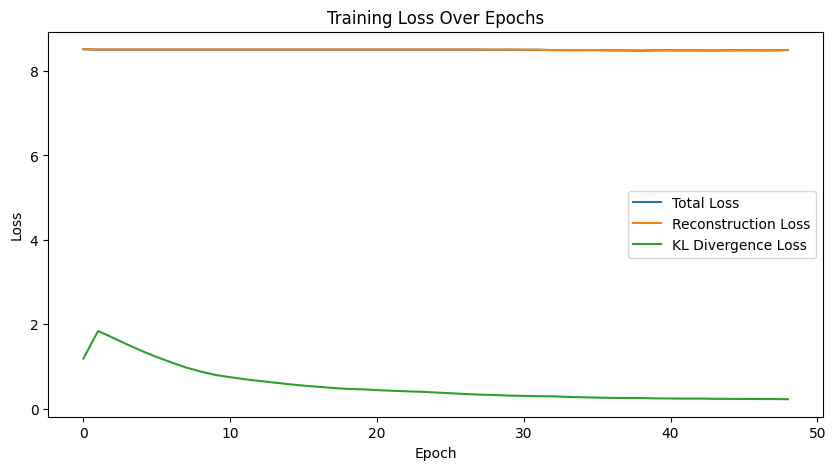

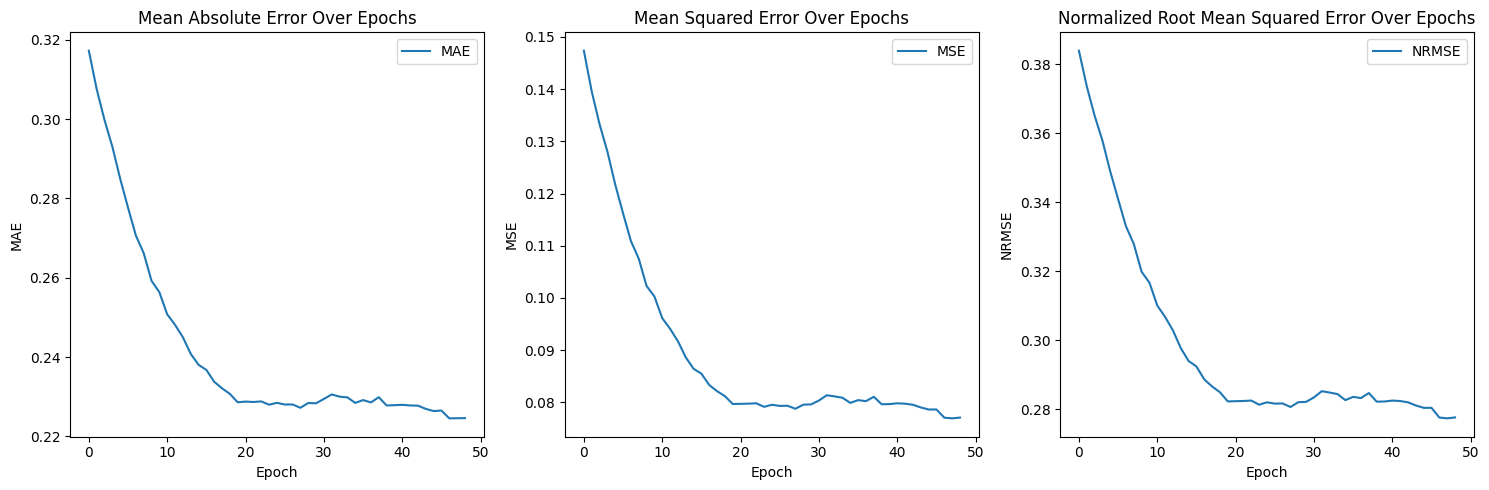

In [4]:
# Cell 4 (modified)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 100
early_stopping_patience = 10
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\annek\AppData\Local\Temp\ipykernel_14108\737372651.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


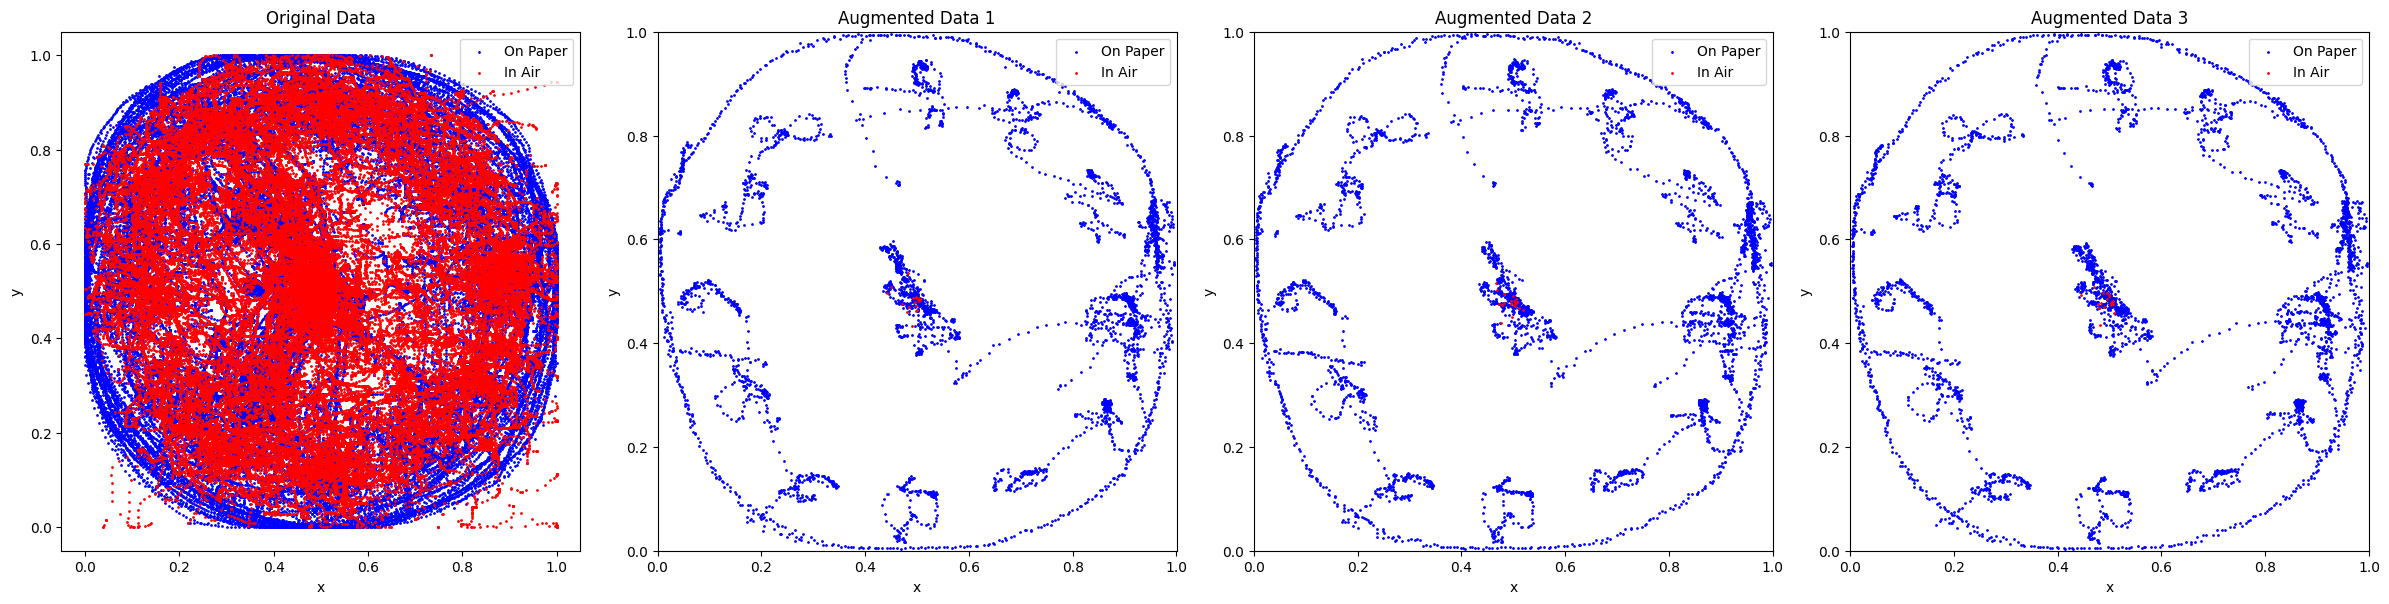

In [6]:
# Cell 5 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets

num_augmented_files = 3
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 2] == 1]
original_in_air = combined_data[combined_data[:, 2] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 2] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 2] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()
